# Lab2 - EA for Set Covering Problem

# Libraries

In [382]:
import numpy as np
import logging
from collections import namedtuple
import random
from matplotlib import pyplot as plt
import time

# Code

## Problem instance generator

In [383]:
def problem(N: int, seed=42):
    """Creates an instance of the problem"""

    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

## Evolutionary Algorithm

### Fitness

- The fitness evaluate how fit a given solution is in solving the set covering problem. Set covering problem looks to minimize the size of the final solution to get all number in range(N). That is why we will use the bloat ratio, The objective is also to get normalized values independing of N. 
- At the end our scores will be centralized on 0 and the unexpected solution will be pushed on left size if too small or right side if too big from our solutions distribution 

In [384]:
def fitness(genome: list,N: int):
    """ Definition of the fitness"""
    return sum(len(_) for _ in genome)

### Tournament

The set covering problem is a minimisation problem, therefore we will try to minimize it. As we are looking to the values closest to zero, we can use the absolute value of the fitness

In [385]:
def tournament(population: list, tournament_size=2):
    """Tournament function"""
    return min(random.choices(population, k=tournament_size), key=lambda i: abs(i.fitness))

### Cross-Over

As seen in cass, I take a random point of my genome and then I cut at this point. The cut must be maximum the length of the smallest genome

In [386]:
def cross_over(g1: list, g2: list):
    cut = random.randint(1, min([len(g1),len(g2)]))
    return g1[:cut] + g2[cut:]

### Mutation

Three types of mutation:
- if len(genome) < Len(goal) ==> insertion of random array from the initial set
- if len(genome) > len(goal) ==> deletion of a random array
- if len(genome) == len(goal) ==> change random value with one from the initial set

In [387]:
def mutation(g: list,goal: set, initial_set:list):
    if sum(len(_) for _ in g) > len(goal):
        point = random.randint(0, len(g)-1)
        del g[point]
    elif sum(len(_) for _ in g) < len(goal):
        point = random.randint(0, len(initial_set)-1)
        g.append(initial_set[point])
    else:
        point1 = random.randint(0, len(g)-1)
        point2 = random.randint(0, len(initial_set)-1)
        del g[point1]
        g.append(initial_set[point2])
    return g

### Genetic Algorithm

In [388]:
logging.getLogger().setLevel(logging.INFO)

#### Initial Population

##### Infeasible Solutions
- Our problem provide us a lot of an infeasible solution therefore it is better to take this values. 
- As the heuristic repair could be dangerous, I will not use it
- We will give a penalty to them. As set covering problem is a minminization problem, we will try to maximize this values
- According, we will provide a factor of 1000 * N.

In [389]:
def feasible(solution, GOAL):
    return set([el for array in solution for el in array]) == GOAL

In [390]:
def penalty(value,N):
    return value*N*100

##### Function

In [391]:
Individual = namedtuple("Individual", ["genome", "fitness"])
def initial_population(N: int,POP_SIZE: int,seed = 42):
    """ Initialisation of the population according to feasibility"""
    population = list()
    initial_set = problem(N,seed)
    GOAL = set(list(range(N)))
    for values in range(POP_SIZE):
       genome = random.sample(initial_set,random.randint(1,N))# The ideal solution is N array of length 1 with all value
       if feasible(genome,GOAL):
           population.append(Individual(genome,fitness(genome,N)))
       else:
           population.append(Individual(genome, penalty(fitness(genome,N),N)))
    logging.info(f"init: N={N} pop_size={len(population)}; min_bloat_init={(min(population, key=lambda i: abs(i.fitness))[1]-N)/N}")
    return population,initial_set

#### Performance Evolution

In [393]:
def plot_result(fitness_log,NUM_GENERATIONS ):
    off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(NUM_GENERATIONS)]
    on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(NUM_GENERATIONS)]
    gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]

    plt.figure(figsize=(15, 6))
    #plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
    plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
    plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
    plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])



#### Evolution

In [394]:
fitness_log = []
def evolution(N: int,population: list,POPULATION_SIZE: int, NUM_GENERATIONS:int, OFFSPRING_SIZE:int,initial_set:list):
    fitness_log = [(0, i.fitness) for i in population]
    GOAL = set(list(range(N)))
    for g in range(NUM_GENERATIONS):
        offspring = list()
        for i in range(OFFSPRING_SIZE):
            if random.random() < 0.3:
                p = tournament(population)
                o = mutation(p.genome,GOAL,initial_set)
            else:
                p1 = tournament(population)
                p2 = tournament(population)
                o = cross_over(p1.genome, p2.genome)
            if feasible(o,GOAL):
                f = fitness(o,N)
            else:
                f = penalty(fitness(o,N),N)
            fitness_log.append((g+1, f))
            offspring.append(Individual(o, f))
        population += offspring
        population = sorted(population, key=lambda i: abs(i.fitness))[:POPULATION_SIZE]
    plot_result(fitness_log,10*N)
    return population

In [395]:
def algorithm(N):
    POPULATION_SIZE = N*N
    OFFSPRING_SIZE = 3
    NUM_GENERATIONS = 100*N
    ### Initialisation of the problem
    population,initial_set = initial_population(N,POPULATION_SIZE)
    ### Evolution
    return evolution(N,population,POPULATION_SIZE,NUM_GENERATIONS,OFFSPRING_SIZE,initial_set)

INFO:root:init: N=5 pop_size=25; min_bloat_init=0.0
INFO:root:Top 3 bests results for 5: [0.0, 0.0, 0.0]
INFO:root:Found in 0.0529 s
INFO:root:init: N=10 pop_size=100; min_bloat_init=0.9
INFO:root:Top 3 bests results for 10: [0.0, 0.0, 0.0]
INFO:root:Found in 0.1559 s
INFO:root:init: N=20 pop_size=400; min_bloat_init=0.75
INFO:root:Top 3 bests results for 20: [0.2, 0.2, 0.2]
INFO:root:Found in 0.4932 s
INFO:root:init: N=50 pop_size=2500; min_bloat_init=1.42
INFO:root:Top 3 bests results for 50: [0.6, 0.64, 0.84]
INFO:root:Found in 3.6988 s
INFO:root:init: N=100 pop_size=10000; min_bloat_init=1.6
INFO:root:Top 3 bests results for 100: [1.32, 1.51, 1.52]
INFO:root:Found in 25.3768 s


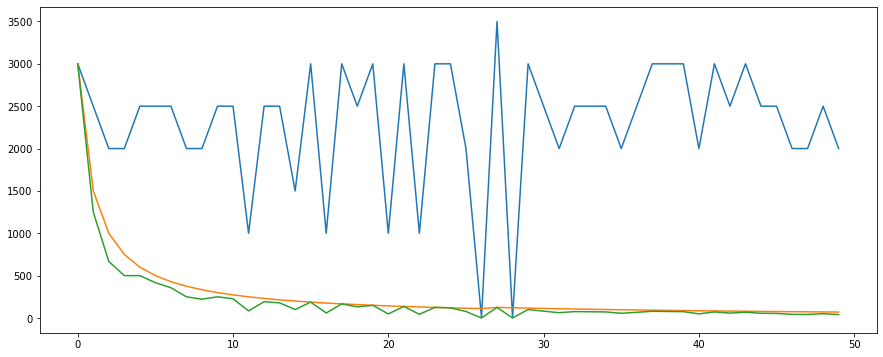

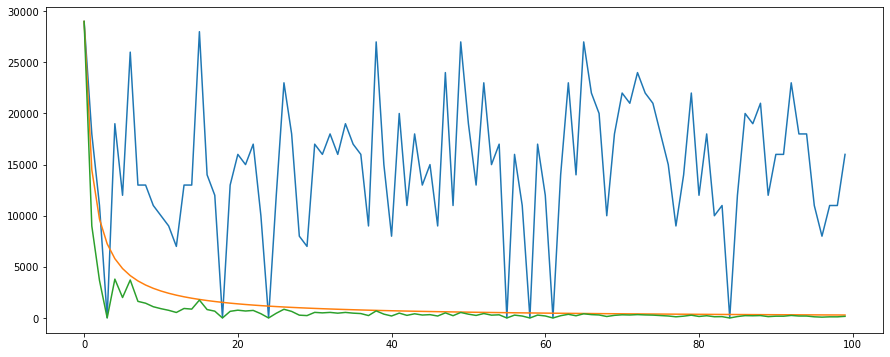

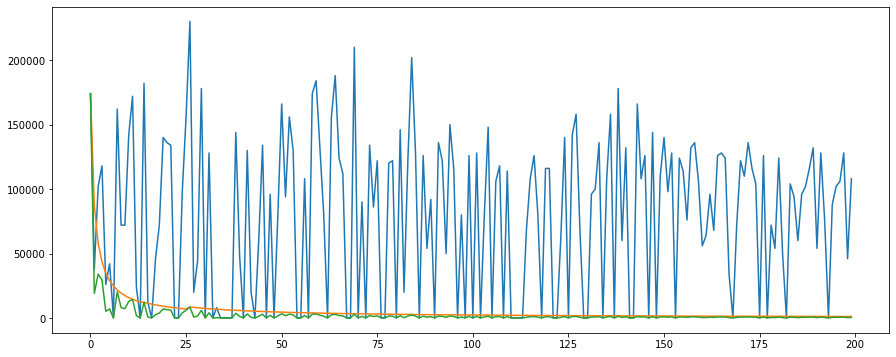

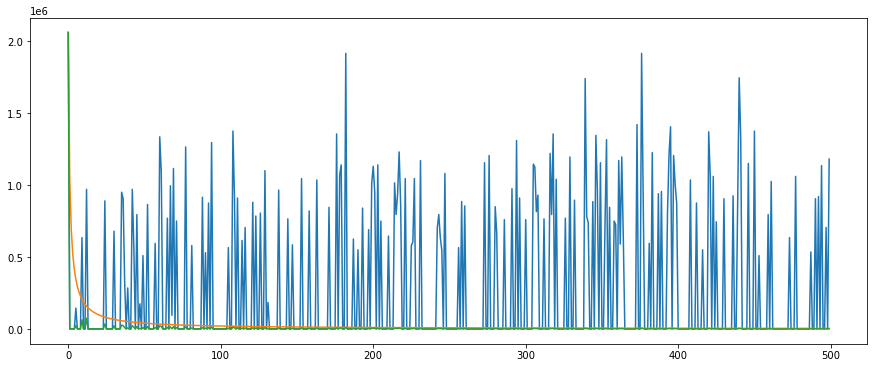

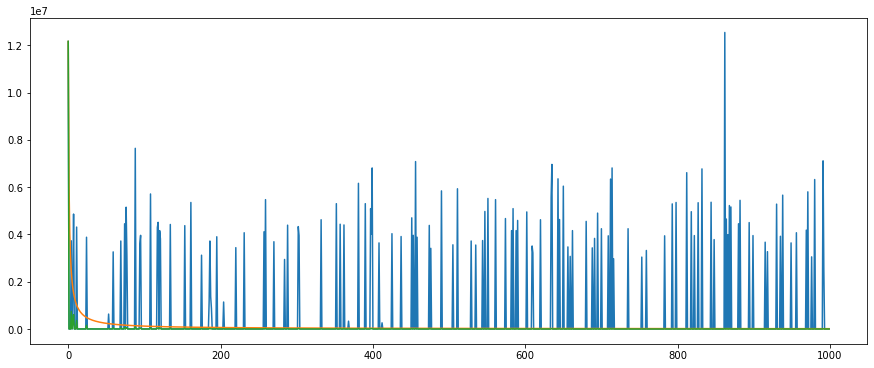

In [396]:
tic = time.perf_counter()
for N in [5,10,20,50,100]:
    results = algorithm(N)[:3]
    logging.info(f'Top 3 bests results for {N}: {[(el.fitness-N)/N for el in results]}')
    toc = time.perf_counter()
    logging.info(f'Found in {toc-tic:0.4f} s')